## Analyzing OpenTransit Bus Location Data - Average Wait Time

This notebook presents an example of working with the bus arrival data. We'll take the bus arrivals from routes 1 and 14 and examine the wait times at each stop on each route.

In [21]:
import json

from datetime import datetime, timedelta, timezone, time, date

import pandas as pd
import numpy as np

In [22]:
%matplotlib inline

## Load the Data

In [23]:
def load_json(filename = 'sample_routes_stops_pst_15s.json'):
    with open(filename, 'r') as f:
        return json.load(f)

In [24]:
test = pd.DataFrame(load_json()).drop(labels = 'index', axis = 'columns')

In [25]:
test.sample(10)

,DID,ROUTE,SID,TIME,VID
13977,1____O_F00,1,3892,1539613538000,5626
18473,1____I_F00,1,6310,1539652251000,5576
8842,14___I_F00,14,7945,1539603095000,5422
9288,14___I_F00,14,7099,1539639302000,7238
10881,1____O_F00,1,6316,1539629669000,5638
18081,1____I_F00,1,6292,1539623607000,5545
5636,14___I_F00,14,5610,1539629024000,7279
13028,1____O_F00,1,6319,1539643998000,5638
11924,1____O_F00,1,6303,1539646189000,5624
14528,1____O_F00,1,3852,1539632460000,5553


## Computing Wait Times

Our goal is to compute the average wait time, at a stop on a route, over a given period of time. We'll do this in two steps:

- Compute the wait time at a stop for every minute in the given timespan
- Average over these wait times

In [26]:
# find the smallest nonnegative waiting time
def absmin(series):
    return series[series >= 0].min()

# finds the wait times for data from a single day
def get_daily_wait_times(df, start_time, end_time, group):
    minute_range = [start_time + timedelta(minutes=i) for i in range(
        (end_time - start_time).seconds//60)]
    wait_times = pd.DataFrame(columns=[])

    for minute in minute_range:
        # TODO (jtanquil): we get this error, see if you can fix it
        # A value is trying to be set on a copy of a slice from a DataFrame.
        # Try using .loc[row_indexer,col_indexer] = value instead
        # See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
        #   df['WAIT'] = df['timestamp'].apply(lambda x: (x - minute).total_seconds())
        df['WAIT'] = df['TIME'].apply(lambda x: (x - minute).total_seconds())
        pivot = df[group + ['WAIT']].pivot_table(values = ['WAIT'], index = group, aggfunc = absmin)
        pivot['TIME'] = minute
        pivot = pivot.reset_index()
        wait_times = wait_times.append(pivot, sort = True)

    return wait_times

def get_all_wait_times(df, timespan = ("00:00", "23:59"), group = ['ROUTE']): #probably restrict timespan to when buses are actually running
    # process arrivals df
    arrivals = df.copy(deep = True)
    arrivals['TIME'] = arrivals['TIME'].apply(lambda x: datetime.fromtimestamp(x/1000, timezone(timedelta(hours = -8))))
    arrivals['DATE'] = arrivals['TIME'].apply(lambda x: x.date())
    
    dates = arrivals['DATE'].unique()
    avg_over_pd = pd.DataFrame(columns = group + ['DATE', 'TIME', 'WAIT'])

    for date in dates:
        #print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: start processing {date}.")
        start_time = datetime.strptime(f"{date.isoformat()} {timespan[0]} -0800", "%Y-%m-%d %H:%M %z")
        end_time   = datetime.strptime(f"{date.isoformat()} {timespan[1]} -0800", "%Y-%m-%d %H:%M %z")
        daily_wait = get_daily_wait_times(arrivals[arrivals['DATE'] == date], start_time, end_time, group)
        #print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: found waits for {date}.")
        #daily_wait = daily_wait.pivot_table(values = ['WAIT'], index = group).reset_index()
        daily_wait['DATE'] = date
        daily_wait['TIME'] = daily_wait['TIME'].apply(lambda x: x.time())
        avg_over_pd = avg_over_pd.append(daily_wait, sort = True)

    return avg_over_pd

These functions, together, will return a DataFrame containing the wait times for every minute over the given time period. The `group` parameter allows us to aggregate wait times by certain properties - for instance, if we want to get all of the wait times for each stop of each route, we'll need to aggregate the arrivals by `SID` and `ROUTE`. 

With this DataFrame, we can compute the average wait time, in addition to any other summary statistics we want:

In [27]:
def quantiles(series):
    return [np.percentile(series, i) for i in [5, 25, 50, 75, 95]]

def get_summary_statistics(df, group):
    waits = df.pivot_table(values = ['WAIT'], index = group, aggfunc = {'WAIT': [np.mean, np.std, quantiles]}).reset_index()
    waits.columns = ['_'.join(col) if col[0] == 'WAIT' else ''.join(col) for col in waits.columns.values]
    waits[[f"{i}th percentile" for i in [5, 25, 50, 75, 95]]] = waits['WAIT_quantiles'].apply(lambda x: pd.Series(x))
    waits = waits.drop('WAIT_quantiles', axis = 1)
    return waits

In [28]:
def get_avg_wait_times(df, timespan = ("05:00", "23:59"), group = ['ROUTE']): # defaulting to muni operating hours
    return get_summary_statistics(get_all_wait_times(df, timespan, group), group)

In [29]:
avg_wait_times = get_avg_wait_times(test, timespan = ("08:00", "17:00"), group = ['ROUTE', 'SID'])

C:\Users\jose\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
avg_wait_times.sample(10)

,ROUTE,SID,WAIT_mean,WAIT_std,5th percentile,25th percentile,50th percentile,75th percentile,95th percentile
13,1,3828,248.907407,202.332701,16.00,88.00,201.0,372.75,618.00
60,1,4028,293.653704,243.663924,19.00,99.00,226.0,432.25,784.40
121,14,5552,488.487037,355.725700,41.00,193.75,423.5,710.50,1153.15
151,14,5594,507.216667,384.798629,43.00,212.50,421.5,707.25,1258.30
64,1,4277,238.274074,204.182734,14.00,88.00,192.0,326.75,650.70
179,14,5693,458.218519,351.506074,29.95,179.75,380.5,675.25,1156.20
124,14,5557,435.640741,337.080305,31.00,167.00,372.5,618.50,1093.15
156,14,5599,417.470370,306.306165,33.00,167.00,372.5,587.50,993.40
109,14,5538,470.729630,329.398965,44.95,207.00,407.5,691.00,1083.15
48,1,4016,257.679630,217.089337,16.00,88.75,203.0,373.25,681.30


Finally, the wait times themselves can be useful for analysis and visualization.

In [31]:
waits = get_all_wait_times(test, timespan = ("08:00", "17:00"), group = ['ROUTE', 'SID'])

C:\Users\jose\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
waits.sample(10)

,DATE,ROUTE,SID,TIME,WAIT
43,2018-10-15,1,3892,09:24:00,267.0
154,2018-10-15,14,5597,13:26:00,632.0
101,2018-10-15,14,5530,16:40:00,111.0
164,2018-10-15,14,5609,11:48:00,285.0
92,2018-10-15,1,6320,16:24:00,50.0
73,2018-10-15,1,6298,09:19:00,27.0
143,2018-10-15,14,5584,11:04:00,239.0
38,2018-10-15,1,3876,13:41:00,77.0
113,2018-10-15,14,5542,08:45:00,371.0
35,2018-10-15,1,3858,16:08:00,185.0


In [33]:
waits.describe()

,WAIT
count,101520.000000
mean,350.057082
std,300.816531
min,0.000000
25%,122.000000
50%,270.000000
75%,498.000000
max,1970.000000


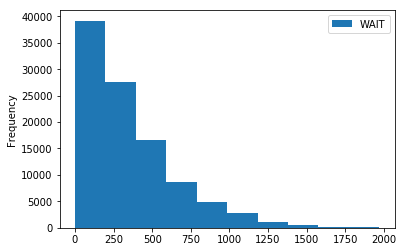

In [38]:
waits.plot.hist()